# Simple FRAP script
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/omero-guide-python/blob/master/notebooks/SimpleFRAP.ipynb)

This script analyzes a fluorescence time-lapse image, measuring the intensity in a named Channel within a ROI. The intensity is plotted over time.

### Install dependencies if required
The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). 

In [1]:
# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp310-cp310-manylinux_2_28_x86_64.whl
# Package required to interact with IDR or OMERO
%pip install omero-py==5.19.2

## Import packages

In [1]:
from omero.gateway import BlitzGateway, MapAnnotationWrapper
from omero.model import EllipseI
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from getpass import getpass
# only used in the Jupyter notebook context for displaying a plot:
from IPython.display import Image as ipImage, display
import ipywidgets as widgets

## Create a connection to the OMERO Server

You will be asked to enter username and password when running the next cell. Please press Enter after each. 

In [2]:
def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(60)
    return conn

HOST = 'wss://workshop.openmicroscopy.org/omero-ws'
conn = connect(HOST, input("Username: "), getpass("OMERO Password: "))
print("Connected as {}".format(conn.getUser().getName()))

Username:  trainer-1
OMERO Password:  ········


Connected as trainer-1


## Load Image

In [3]:
image_id = input("Image ID: ")
img = conn.getObject("Image", image_id)
print("Image {} loaded".format(img.getName()))

Image ID:  28662


Image U20S-RCC1.10_R3D_FRAP.dv loaded


## Select the relevant channel

In [4]:
def dropdown_widget(values,
                    dropdown_widget_name,
                    displaywidget=False):

    alg_sel = widgets.Dropdown(
        options=values,
        value=values[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(alg_sel)
    return alg_sel

labels = img.getChannelLabels()
channel_name = dropdown_widget(
    img.getChannelLabels(),
    'Name: ', True
)

Dropdown(description='Name: ', options=('528.0', '1', '2'), value='528.0')

In [5]:
channel_idx = labels.index(channel_name.value)
print("Channel index: {}".format(channel_idx))

Channel index: 0


## Get the ellipse ROI:

In [6]:
def get_ellipse_roi(conn, image):
    """
    Get the first ellipse ROI found in the image
    :param conn: The BlitzGateway
    :param image: The Image
    :return: The shape ID of the first ellipse ROI found
    """
    roi_service = conn.getRoiService()
    result = roi_service.findByImage(image.getId(), None)
    shape_id = None
    for roi in result.rois:
        for s in roi.copyShapes():
            if type(s) == EllipseI:
                shape_id = s.id.val
    return shape_id

ellipse_id = get_ellipse_roi(conn, img)
print("Shape ID: {}".format(ellipse_id))

Shape ID: 2067304


## Get the mean intensities

In [7]:
def get_mean_intensities(conn, image, the_c, shape_id):
    """
    Get the mean pixel intensities of a ROI in a time series image
    :param conn: The BlitzGateway
    :param image: The image
    :param the_c: The channel index
    :param shape_id: The ROI shape id
    :return: List of mean intensity values (one for each timepoint)
    """
    roi_service = conn.getRoiService()
    the_z = 0
    size_t = image.getSizeT()
    meanvalues = []
    for t in range(size_t):
        stats = roi_service.getShapeStatsRestricted([shape_id],
                                                    the_z, t, [the_c])
        meanvalues.append(stats[0].mean[0])
    return meanvalues

values = get_mean_intensities(conn, img, channel_idx, ellipse_id)
print(values)

[287.48524234169406, 276.46646941335575, 270.09629821777344, 139.07519551327354, 152.9218312815616, 160.5943051388389, 167.5860084734465, 173.7293785496762, 178.01229025188246, 182.5849669607062, 187.2157184199283, 190.51632288882607, 194.66981717159874, 197.61024485136332, 200.80241956208883, 202.45595620807848, 204.38025655244527, 207.00919251692923, 208.20408770912573, 211.28397078263131, 213.07126978824013, 216.4378325813695, 218.38828458284078, 218.68307103608785, 220.4650041680587, 220.1416809684352, 222.28871134707802, 223.28039560819926, 222.75595524436548, 224.35019633644507, 224.09511184692383, 225.55639799017655, 227.83410905536851, 227.41890415392425, 228.06322690060264, 227.3284357974404, 227.09195739344545, 228.9166102158396, 228.779549749274, 229.96900719090513, 229.15343425148413, 230.5665205905312, 231.55242417988023, 230.12088976408305, 231.9381594406931, 233.1758010261937, 231.51929674650492, 231.6885616904811, 231.0371178074887, 228.50869911595396, 230.0962487270957

## Plot the data

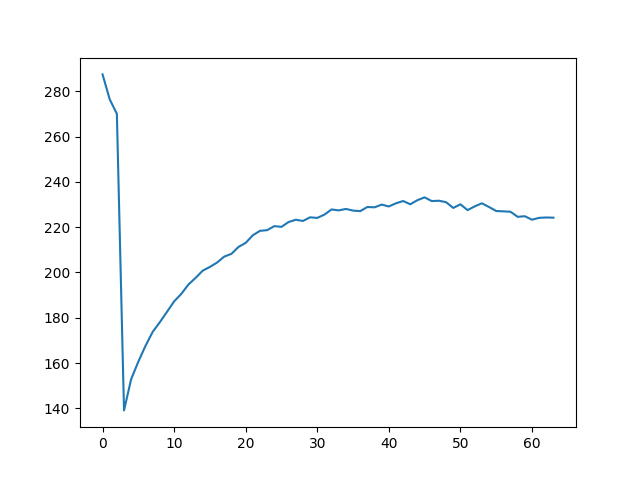

In [8]:
def plot(values, plot_filename):
    """
    Create a simple plot of the given values
    and saves it.
    :param values: The values
    :param plot_filename: The file name
    :return: Nothing
    """
    matplotlib.use('Agg')
    fig = plt.figure()
    plt.subplot(111)
    plt.plot(values)
    fig.canvas.draw()
    fig.savefig(plot_filename)
    pil_img = Image.open(plot_filename)
    pil_img.show()

plot(values, "plot.png")
display(ipImage("plot.png"))

## Save the results

In [9]:
def save_values(conn, image, values):
    """
    Attach the values as map annotation to the image
    :param conn: The BlitzGateway
    :param image: The image
    :param values: The values
    :return: Nothing
    """
    namespace = "demo.simple_frap_data"
    key_value_data = [[str(t), str(value)] for t, value in enumerate(values)]
    map_ann = MapAnnotationWrapper(conn)
    map_ann.setNs(namespace)
    map_ann.setValue(key_value_data)
    map_ann.save()
    image.linkAnnotation(map_ann)
    
save_values(conn, img, values)
print("Values saved.")

Values saved.


In [10]:
def save_plot(conn, image, plot_filename):
    """
    Save the plot to OMERO
    :param conn: The BlitzGateway
    :param image: The image
    :param plot_filename: The path to the plot image
    :return: Nothing
    """
    pil_img = Image.open(plot_filename)
    np_array = np.asarray(pil_img)
    red = np_array[::, ::, 0]
    green = np_array[::, ::, 1]
    blue = np_array[::, ::, 2]
    plane_gen = iter([red, green, blue])
    conn.createImageFromNumpySeq(plane_gen, plot_filename, sizeC=3,
                                     dataset=image.getParent())
    
save_plot(conn, img, "plot.png")
print("Plot saved.")

Plot saved.


## Close the connection

In [11]:
def disconnect(conn):
    """
    Disconnect from an OMERO server
    :param conn: The BlitzGateway
    """
    conn.close()

disconnect(conn)

### License (BSD 2-Clause)
Copyright (C) 2019-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.